In [5]:
import sys
sys.path.append('/home/yifan/projects/Trustvis')
from singleVis.data import NormalDataProvider
tar_CONTENT_PATH='/home/yifan/datasets/MNIST_Backdoor/white_lower_left_4'
ref_CONTENT_PATH = '/home/yifan/datasets/MNIST_Clean/01'
epoch = 5
sys.path.append(ref_CONTENT_PATH)
import Model.model as subject_model
net = eval("subject_model.{}()".format('resnet18'))


ref_data_provider = NormalDataProvider(ref_CONTENT_PATH , net, epoch, epoch, 1, device='cuda:0', epoch_name='Epoch',classes=[],verbose=1)
tar_data_provider =  NormalDataProvider(tar_CONTENT_PATH , net, epoch, epoch, 1, device='cuda:0', epoch_name='Epoch',classes=[],verbose=1)

ref_data = ref_data_provider.train_representation(epoch)
ref_data = ref_data.reshape(ref_data.shape[0],ref_data.shape[1])
tar_data = tar_data_provider.train_representation(epoch)
tar_data = tar_data.reshape(tar_data.shape[0],tar_data.shape[1])

ref_pred = ref_data_provider.get_pred(epoch,ref_data)
tar_pred = tar_data_provider.get_pred(epoch,tar_data)

Finish initialization...
Finish initialization...


100%|██████████| 300/300 [00:00<00:00, 7680.66it/s]


In [16]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
def eval_clustering(X, range_n_clusters):
    """
        silhouette_score:
            Higher values indicate that the clusters are tighter and well separated
        Calinski-Harabasz: 
            Higher values indicate small internal differences and large internal differences,
        Davies-Bouldin: Lower values indicate better clustering
    """

    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []

    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # 轮廓系数
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        # Calinski-Harabasz指数
        ch_score = calinski_harabasz_score(X, cluster_labels)
        calinski_harabasz_scores.append(ch_score)

        # Davies-Bouldin指数
        db_score = davies_bouldin_score(X, cluster_labels)
        davies_bouldin_scores.append(db_score)
        print("{} clusters silhouette_avg is {}, Calinski-Harabasz is{} and Davies-Bouldin is{}".format(n_clusters, silhouette_avg,ch_score,db_score ))
    
    return silhouette_scores,calinski_harabasz_scores,davies_bouldin_scores
    


In [34]:
clusterer = KMeans(n_clusters=10, random_state=10)
ref_cluster_labels = clusterer.fit_predict(ref_data)
ref_c = clusterer.cluster_centers_
tarClusterer = KMeans(n_clusters=10, random_state=10)
tar_cluster_labels = tarClusterer.fit_predict(tar_data)
tar_c = tarClusterer.cluster_centers_

In [35]:
ref_c_pred = ref_data_provider.get_pred(epoch, ref_c)
tar_c_pred = tar_data_provider.get_pred(epoch, tar_c)

100%|██████████| 1/1 [00:00<00:00, 6132.02it/s]


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# 计算余弦相似度矩阵
cosine_sim_matrix = cosine_similarity(ref_c_pred, tar_c_pred)

# 对于ref_c_pred中的每一个中心，找到与之最相似的tar_c_pred中的中心
matches = np.argmax(cosine_sim_matrix, axis=1)


In [38]:
tar_c = tar_c[matches]

In [54]:
diff_ref = ref_data[:, np.newaxis, :] - ref_c[np.newaxis, :, :]
distance_to_c_ref = np.sqrt(np.sum(diff_ref ** 2, axis=2))
diff_tar = tar_data[:, np.newaxis, :] - tar_c[np.newaxis, :, :]
distance_to_c_tar = np.sqrt(np.sum(diff_tar ** 2, axis=2))

In [83]:
"""
distance to center consistency
"""
from scipy.stats import spearmanr
def consistency_score(distance_to_c_ref, distance_to_c_tar):
    scores = []
    for ref_distances, tar_distances in zip(distance_to_c_ref, distance_to_c_tar):
        # 对每个样本到各个中心点的距离进行排序
        ref_sorted_indices = np.argsort(ref_distances)
        tar_sorted_indices = np.argsort(tar_distances)
        
        # 计算Spearman等级相关系数
        coef, _ = spearmanr(ref_sorted_indices, tar_sorted_indices)
        scores.append(coef)
    
    return np.array(scores)

scores = consistency_score(distance_to_c_ref, distance_to_c_tar)

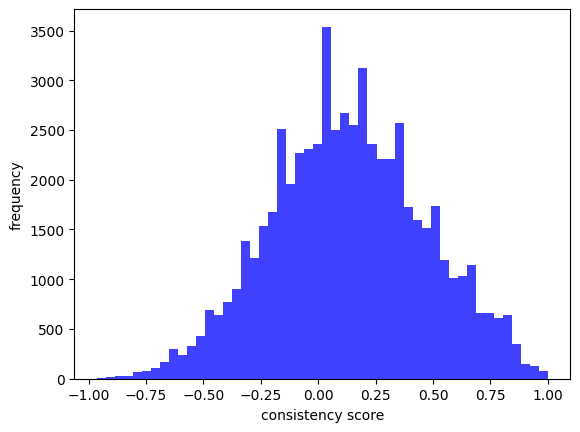

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制 scores 的分布柱状图
plt.hist(scores, bins=50, alpha=0.75, color='blue')
plt.xlabel('consistency score')
plt.ylabel('frequency')
plt.show()


In [88]:
indicates = np.where(scores > 0)[0]
print(len(indicates))


38918


In [89]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(ref_data)
_, ref_nn_indices = nbrs.kneighbors(ref_data)
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(tar_data)
_, tar_nn_indices = nbrs.kneighbors(tar_data)
common_nn_counts = np.zeros(len(ref_nn_indices), dtype=int)
for i in range(len(ref_nn_indices)):
    common_nn_counts[i] = np.intersect1d(ref_nn_indices[i], tar_nn_indices[i]).size

In [111]:
common_nn_counts_rate = common_nn_counts/15
topologyScore = scores + common_nn_counts_rate
aligned = np.where(topologyScore > 0.5)[0]
print("aligned number", len(aligned))

aligned number 22003


In [114]:
"""
Mapper: transfomrmation different representations
high d to high d
"""
import torch
import torch.optim as optim
# Define the autoencoder
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self, input_dim=512, encoding_dim=256,hidden_dim=256):
        super(Autoencoder, self).__init__()
        
        # Encoder: tar to ref
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU()
        )
        
        # Decoder: ref to tar
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


  
class TransformationTrainer():
    def __init__(self,ref_data,tar_data,ref_provider,tar_provider,ref_epoch,tar_epoch,device,n_neighbors=15) -> None:
        self.ref_data = ref_data
        self.tar_data = tar_data
        # self.ref_proxy = ref_proxy
        # self.tar_proxy = tar_proxy
        self.n_neighbors = n_neighbors
        self.ref_provider = ref_provider
        self.tar_provider = tar_provider
        self.ref_epoch = ref_epoch
        self.tar_epoch= tar_epoch
        self.device = device
        self.model = Autoencoder().to(device)
        self.ref_data = self.ref_data.reshape(self.ref_data.shape[0],self.ref_data.shape[1])
        self.tar_data = self.tar_data.reshape(self.tar_data.shape[0],self.tar_data.shape[1])
        self.tar_pred = self.tar_provider.get_pred(self.tar_epoch, self.tar_data)
        self.ref_pred = self.ref_provider.get_pred(self.ref_epoch, self.ref_data)

    
    
    def transformation_train(self,aligned_indicates, lambda_translation=0.5,num_epochs = 100,lr=0.001):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        # Assume tar_tensor and ref_tensor are your data in PyTorch tensor format
        print("finished aligned")
        #TODO
        # self.tar_train = np.concatenate((self.tar_data, self.tar_proxy),axis=0)
        # self.ref_train = np.concatenate((self.ref_data, self.ref_proxy),axis=0)
        self.tar_train = self.tar_data[aligned_indicates]
        self.ref_train = self.ref_data[aligned_indicates]
        tar_tensor = torch.tensor(self.tar_train, dtype=torch.float32).cuda() 
        ref_tensor = torch.tensor(self.ref_train, dtype=torch.float32).cuda()
        tar_tensor = tar_tensor.to(self.device)
        ref_tensor = ref_tensor.to(self.device)
        # knn_overlap_loss = KNNOverlapLoss(k=15)

        # Train the autoencoder
        for epoch in range(num_epochs):
            self.model.train()

            optimizer.zero_grad()

            # Forward pass
            latent_representation = self.model.encoder(tar_tensor)
            outputs = self.model.decoder(latent_representation)

            # Compute the two losses
            reconstruction_loss = criterion(outputs, tar_tensor)
            translation_loss = criterion(latent_representation, ref_tensor)

            # Combine the losses
            loss = reconstruction_loss + lambda_translation * translation_loss
            # + lambda_knn * (knn_loss_encoder + knn_loss_decoder) 
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

        # To get the mapped version of tar
        tar_mapped = self.model.encoder(tar_tensor).cpu().detach().numpy()

        tar_data_shape = self.tar_data.shape[0]
        tar_data_mapped = tar_mapped[:tar_data_shape]

        

        # To get ref back from the mapped tar
        ref_reconstructed = self.model.decoder(torch.tensor(tar_mapped).to(self.device)).cpu().detach().numpy()

        return self.model, tar_data_mapped, ref_reconstructed
    

    


In [123]:
from Transformation.transform import TransformationTrainer
Transformation_Trainer = TransformationTrainer(ref_data,tar_data,ref_data_provider,tar_data_provider,epoch,epoch,'cuda:0',15)

/home/yifan/anaconda3/envs/visualizer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 300/300 [00:00<00:00, 7545.25it/s]


In [124]:
trans_model,tar_data_mapped,tar_proxy_mapped,ref_reconstructed  = Transformation_Trainer.transformation_train(num_epochs=1000)

diff is 1141
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 6070
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 6237
Number of matching elements: 6237
Number of matching elements: 5943
Number of matching elements: 5795
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 5894
Number of matching elements: 5795
Number of matching elements: 5720
Number of matching elements: 5720
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 6070
Number of matching elements: 5943
Number of matching elements: 6070
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 5943
Number of matching elements: 5795
Number of matching elements: 5720
Number of matching elements: 5943
N

In [125]:
from eval.evaluate import *
def eval_inv_train(epoch,train_data, data_provider,n_data_provider, embedding):
        pred = data_provider.get_pred(epoch, train_data).argmax(axis=1)
        new_pred = n_data_provider.get_pred(epoch, embedding).argmax(axis=1)

        val = evaluate_inv_accu(pred, new_pred)
        # val_error = evaluate_vis_error(pred, new_pred)
   
        print("#train# PPR: {:.2f} in epoch {:d}".format(val, epoch))
        return val

eval_inv_train(epoch, tar_data, tar_data_provider, ref_data_provider, tar_data_mapped)

100%|██████████| 300/300 [00:00<00:00, 6259.56it/s]

#train# PPR: 1.00 in epoch 5


0.99845